# Logical shadow tomography: $[[5, 1, 3]]$ code example

## Setup

In [1]:
import functools
from joblib import Parallel, delayed
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from tqdm.notebook import tnrange

from base.stabilizer import random_clifford_state, stabilizer_state, StabilizerState, stoc_depolarize_map
from convert import state2state as stabilizer_state_to_qutip_qobj, state2paulis, state2projector

In [2]:
plt.rcParams.update({"font.family": "serif", "font.size": 16})

## Parameters

In [101]:
"""Set experimental parameters."""
num_trajectories: int = 40_000  # Number of trajectories to sample from.
    
use_rho: bool = True             # Do LST with rho.
num_groups_rho: int = 4          # How many groups to split the shadows into for the median of means estimate with rho.
use_rho_squared: bool = True     # Do LST with rho^2.
num_groups_rho_squared: int = 20  # How many groups to split the shadows into for the median of means estimate with rho^2.

pmin: float = 0.00  # Minimum depolarizing noise rate.
pmax: float = 0.50  # Maximum depolarizing noise rate.
step: float = 0.10  # Step for depolarizing noise rates. Values are `np.arange(pmin, pmax + step, step)`.

njobs: int = 2  # Number of parallel workers to use when collecting shadows.

In [102]:
pvalues = np.arange(pmin, pmax + step, step)
N: int = 5
D: int = 2**N + 1
    
step_rho = num_trajectories // num_groups_rho
step_rho_squared = num_trajectories // num_groups_rho_squared

## Collect shadows

### Quantum trajectory simulator

In [5]:
def sample_trajectory(p: float) -> "StabilizerState":
    # Start in the logical subspace.
    state = stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")

    # Apply single-qubit depolarizing noise.
    state = stoc_depolarize_map(state, p)

    # Apply a random clifford.
    state.measure(random_clifford_state(N))
    return state

### Run simulator

In [15]:
all_shadows = []
for i in tnrange(len(pvalues), desc=f"Sampling {num_trajectories} shadows from {len(pvalues)} noise levels"):
    shadows = Parallel(n_jobs=njobs)(
        delayed(sample_trajectory)(pvalues[i]) for _ in range(num_trajectories)
    )
    all_shadows.append(shadows)

Sampling 40000 shadows from 6 noise levels:   0%|          | 0/6 [00:00<?, ?it/s]

## Postprocess

### Convert all shadows to density matrices

In [16]:
def inverse_map(sigma: np.array) -> np.array:
    d = len(sigma)
    return (d + 1) * sigma - np.identity(d)

In [17]:
all_sigmas = []

for i in tnrange(len(all_shadows), desc="Converting all shadows to density matrices"):
    shadows = all_shadows[i]
    sigmas = []
    for j in tnrange(len(shadows), desc=f"Converting shadows to density matrices for noise level p = {pvalues[i]:.3f}", leave=False):
        sigmas.append(inverse_map(stabilizer_state_to_qutip_qobj(shadows[j]).full()))
    all_sigmas.append(sigmas)

Converting all shadows to density matrices:   0%|          | 0/6 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.000:   0%|          | 0/40000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.100:   0%|          | 0/40000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.200:   0%|          | 0/40000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.300:   0%|          | 0/40000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.400:   0%|          | 0/40000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.500:   0%|          | 0/40000 [00:00<?, ?it/s]

In [18]:
"""Projector P."""
state = stabilizer_state("XZZXI", "IXZZX", "XIXZZ", "ZXIXZ", "ZZZZZ")
state.r = 1
projector = functools.reduce(lambda a, b: a * b, state2projector(state))
projector = projector.full()

In [19]:
"""Tests."""
assert np.allclose(projector @ projector, projector)
assert np.allclose(projector.conj().T, projector)

In [20]:
"""Observable O."""
obs = stabilizer_state_to_qutip_qobj(
    stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")
)

# Tests.
evals = np.zeros(2 ** N)
evals[-1] = 1
assert np.allclose(obs.eigenenergies(), evals)

obs = obs.full()

### LST with $\rho$

In [21]:
def sigma_to_numerator_and_denominator(sigma: "StabilizerState") -> Tuple[float, float]:
    """Returns Tr[M^-1 (shadow) P O], Tr[M^-1 (shadow) P]."""
    projected = sigma @ projector
    return np.trace(projected @ obs), np.trace(projected)

In [86]:
def estimate_numerator_and_denominator_from_shadows_rho(sigmas: List[np.ndarray]) -> Tuple[float, float]:
    numerator = 0.0
    denominator = 0.0
    for j in tnrange(len(sigmas), desc=f"Estimating fidelity with ρ from group of {len(sigmas)} shadows", leave=False):
        num, denom = sigma_to_numerator_and_denominator(sigmas[j])
        numerator += num
        denominator += denom
    return numerator, denominator

In [103]:
if use_rho:
    lst_fidelities = []
    # Loop over all noise levels.
    for k in tnrange(len(all_sigmas), desc="Noise levels"):
        sigmas = all_sigmas[k]

        numerators = []
        denominators = []
        for i in tnrange(num_groups_rho, desc=f"Post-processing with all {len(shadows)} shadows"):
            # Get mean estimate for this group.
            group = sigmas[i * step_rho: (i + 1) * step_rho]
            num, den = estimate_numerator_and_denominator_from_shadows_rho(group)
            numerators.append(num)
            denominators.append(den)
        
        # Final estimate is median of means.
        fidelity = np.median(numerators) / np.median(denominators)
        lst_fidelities.append(fidelity)
    lst_fidelities = np.array(lst_fidelities)

Noise levels:   0%|          | 0/6 [00:00<?, ?it/s]

Post-processing with all 40000 shadows:   0%|          | 0/4 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Post-processing with all 40000 shadows:   0%|          | 0/4 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Post-processing with all 40000 shadows:   0%|          | 0/4 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Post-processing with all 40000 shadows:   0%|          | 0/4 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Post-processing with all 40000 shadows:   0%|          | 0/4 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Post-processing with all 40000 shadows:   0%|          | 0/4 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 10000 shadows:   0%|          | 0/10000 [00:00<?, ?it/s]

### LST with $\rho^2$

In [28]:
def sigmas_to_numerator_and_denominator(
    sigma1: np.ndarray, sigma2: np.ndarray
) -> Tuple[float, float]:
    """Returns Tr[M^-1 (shadow1) M^-1(shadow2) P O], Tr[M^-1 (shadow1) M^-1(shadow2) P].
    """
    projected = sigma1 @ sigma2 @ projector
    return np.trace(projected @ obs), np.trace(projected)

In [53]:
def estimate_numerator_and_denominator_from_shadows_rho_squared(sigmas: List[np.ndarray]) -> Tuple[float, float]:
    numerator = 0.0
    denominator = 0.0
    for j in tnrange(len(sigmas), desc=f"Estimating fidelity with ρ^2 from group of {len(sigmas)} shadows", leave=False):
        for k in range(len(sigmas)):
            if k == j:
                continue
            num, denom = sigmas_to_numerator_and_denominator(sigmas[j], sigmas[k])
            numerator += num
            denominator += denom
    return numerator, denominator

In [69]:
if use_rho_squared:
    lst_vd_fidelities = []
    # Loop over all noise levels.
    for k in tnrange(len(all_sigmas), desc="Noise levels"):
        sigmas = all_sigmas[k]

        numerators = []
        denominators = []
        for i in tnrange(num_groups_rho_squared, desc=f"Post-processing with all {len(shadows)} shadows"):
            # Get mean estimate for this group.
            group = sigmas[i * step_rho_squared: (i + 1) * step_rho_squared]
            num, den = estimate_numerator_and_denominator_from_shadows_rho_squared(group)
            numerators.append(num)
            denominators.append(den)
        
        # Final estimate is median of means.
        fidelity = np.median(numerators) / np.median(denominators)
        lst_vd_fidelities.append(fidelity)
    lst_vd_fidelities = np.array(lst_vd_fidelities)

Noise levels:   0%|          | 0/5 [00:00<?, ?it/s]

Post-processing with all 40000 shadows:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Post-processing with all 40000 shadows:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Post-processing with all 40000 shadows:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Post-processing with all 40000 shadows:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Post-processing with all 40000 shadows:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 2000 shadows:   0%|          | 0/2000 [00:00<?, ?it/s]

## Plotting results

In [37]:
def analytic_fidelity(p):
    N = (8 * p ** 2 - 9 * p + 3) * (2 * p - 3) ** 3
    D = 240 * p ** 4 - 720 * p ** 3 + 810 * p ** 2 - 405 * p + 81
    return -N / D

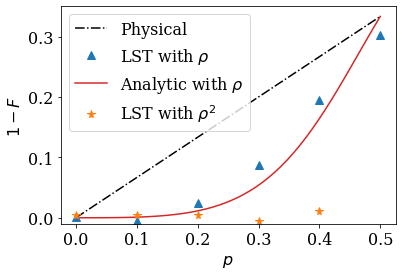

In [106]:
plt.plot(pvalues, 2 * pvalues / 3, "-.", c="k", label="Physical")

if use_rho:
    plt.plot(pvalues, 1.0 - np.real_if_close(lst_fidelities), "^", markersize=8, label=r"LST with $\rho$")
    plt.plot(np.linspace(0, 0.5, 50), 1 - analytic_fidelity(np.linspace(0, 0.5, 50)), c="C3", label=r"Analytic with $\rho$")

if use_rho_squared:
    plt.plot(pvalues, 1.0 - np.real_if_close(lst_vd_fidelities), "*", markersize=8, label=r"LST with $\rho^2$")


# Plot options.
plt.ylim((-0.01, 0.35))
plt.xlabel("$p$")
plt.ylabel("$1 - F$")
plt.legend();

# plt.savefig("lst_vd_513.pdf")